In [1]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
!unzip -q "/content/drive/MyDrive/DLSchool/Домашние задания/14.1 Домашнее задание/journey-springfield/dataset.zip" -d train_data
!unzip -q "/content/drive/MyDrive/DLSchool/Домашние задания/14.1 Домашнее задание/journey-springfield/testset.zip" -d test

In [3]:
pip install split-folders

In [4]:
import splitfolders

In [5]:
"""Разобъем для удобства наш дасет на train и test и разместим в папку data"""
splitfolders.ratio('/content/train_data/train', output="./data", seed=1337,  ratio=(.8, .2))

Copying files: 20933 files [00:03, 5886.38 files/s]


In [6]:
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# папка с данными. Если запускаете в колабе, нужно скопировать данные к себе в директорию и примонтировать диск. Если запускаете локально -- просто скачайте данные
data_dir = './data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [7]:
# папка с данными. Если запускаете в колабе, нужно скопировать данные к себе в директорию и примонтировать диск. Если запускаете локально -- просто скачайте данные
data_dir = './data'

In [8]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f284570ac50>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f2847ef5dd0>}

In [9]:
dataset_sizes

{'train': 16727, 'val': 4206}

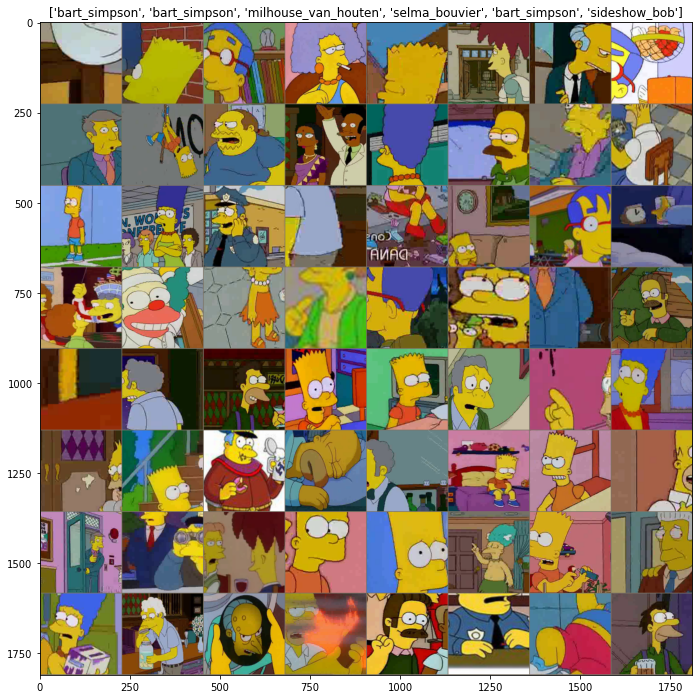

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes[:6]])

## Обучение моделей

Следующая функция будет использоваться для обучения модели + возвращает loss для отрисовки.
Аргументы:

* model  −  нейросеть
* loss  −  оптимизируемая функция (criterion, cost function, objective)
* optimizer  −  оптимизационный алгоритм
* scheduler  −  политика изменения learning_rate
* num_epochs  −  количество итераций обучения

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "val":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            if phase == 'train':
              scheduler.step() # в более поздних версиях ставится после optimizer.step()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

* Функция для отрисовки тестовых изображений и предсказаний для них:

In [12]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

* Функция для измерения точности модели на валидационном датасете

In [13]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

In [14]:
"""не большое отступление как работает torch.max(outpu, -1) берем индексы с max 
значением по нужной оси"""
a = torch.randn(4, 4)
print(a)
torch.max(a, 1)

tensor([[-0.3222,  0.9595,  0.1433,  0.7548],
        [ 1.6066,  0.8168, -0.3881, -0.4919],
        [ 0.4163, -1.3795, -0.0407,  0.7841],
        [-0.3110, -1.1784,  2.9826,  0.5249]])


torch.return_types.max(values=tensor([0.9595, 1.6066, 0.7841, 2.9826]), indices=tensor([1, 0, 3, 2]))

## Fine Tuning способ

  **берем CNN, которую можно дообучить (Fine Tuning)**  
  * Берём сетку, обученную на ImageNet  
  * Убираем последние Fully-Connected слои сети, отвечающие за классификацию.  
  * Теперь всё же *распространяем backpropagation* ещё на сколько-то слоёв назад (размораживаем веса в этих слоях)*, чтобы скорректировать их под новые данные. Можно распространить обучение и на всю сеть, но часто первые слои всё же замораживают, поскольку они (как ожидается) извлекают более общие признаки. А ещё обучать всю сеть всё же дольше, чем несколько слоёв. Всё зависит от того, какого качества Вы хотите добиться
  * Теперь сеть выдаёт не метки классов, а то, что поступало на вход Fully-Connected (веса последних (или всех) слоёв были изменены под наши данные)
  * Обучаем на этих признаках какой-либо классификатор (свою Fully-Connected сеть, например)
  * Теперь у нас есть сеть, работающая хорошо на нашем датасете



## model_alexnet


In [15]:
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [16]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 5 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [18]:
# обучаем
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=8)

Epoch::   0%|          | 0/8 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

Training complete in 12m 1s
Best val Acc: 0.929149


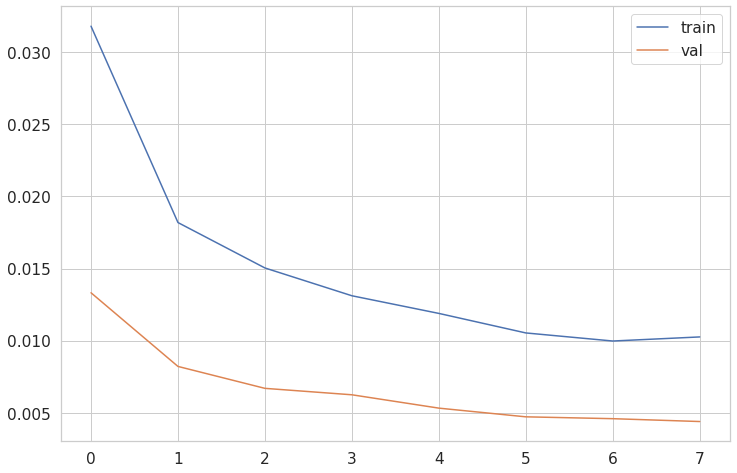

In [19]:
import seaborn as sns

def plot_loss(losses):
  sns.set(style="whitegrid", font_scale=1.4)

  # Построим график лосса при обучении и валидации

  #Ваш код здесь
  plt.figure(figsize=(12, 8))
  plt.plot(losses['train'], label="train")
  plt.plot(losses['val'], label="val")
  plt.legend()
  plt.show()
plot_loss(losses)

Как видно на графике train и val еще не сошлись, думаю кол-во эпох можно увеличить. Шаг exp_lr_scheduler тоже можно увеличить и посмотреть на схождение. 

In [20]:
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth') # сохраняем веса

In [21]:
model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

<All keys matched successfully>

In [22]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.9291


# model_vgg16 

In [23]:
model_vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [24]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_vgg16.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model_vgg16 = model_vgg16.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(model_vgg16.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [25]:
# обучаем
model_vgg16, losses_vgg16 = train_model(model_vgg16, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=8)

Epoch::   0%|          | 0/8 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

Training complete in 19m 41s
Best val Acc: 0.970518


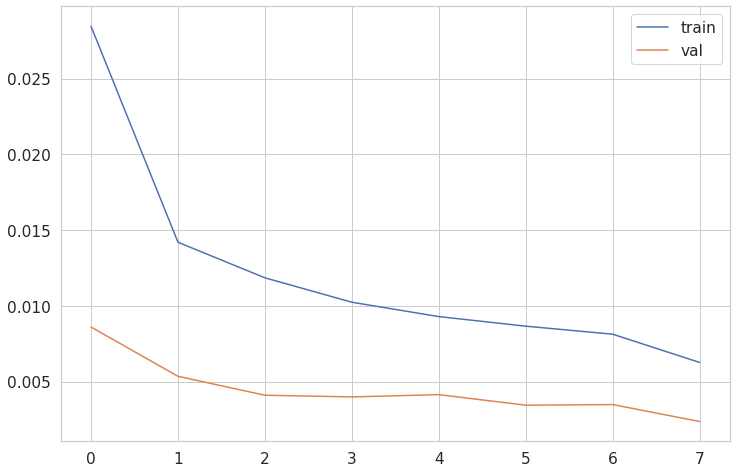

In [26]:
plot_loss(losses_vgg16)

In [27]:
torch.save(model_vgg16.state_dict(), 'model_vgg16_fine_tune.pth') # сохраняем веса

In [28]:
model_vgg16.load_state_dict(torch.load('model_vgg16_fine_tune.pth'))

<All keys matched successfully>

In [29]:
print("Accuracy: {0:.4f}".format(evaluate(model_vgg16)))

Accuracy: 0.9705


In [51]:
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# папка с данными. Если запускаете в колабе, нужно скопировать данные к себе в директорию и примонтировать диск. Если запускаете локально -- просто скачайте данные
data_dir = '/content/test'

image_datasets = datasets.ImageFolder(root=data_dir, transform=data_transforms['val'])
# специальный класс для загрузки данных в виде батчей
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=64,
                                              shuffle=True, num_workers=2)

In [54]:
dataloaders.dataset

['val']

## Feature Extractor способ: заморозка всех весов загруженной модели.

In [ ]:
model_vgg16_extact = models.vgg16(pretrained=True)

In [ ]:
model_vgg16_extact

In [ ]:
# замораживаем параметры (веса)
for param in model_vgg16_extact.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_vgg16_extact.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model_vgg16_extact = model_vgg16_extact.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(model_vgg16_extact.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
for param in model_vgg16_extact.parameters():
    print(param.requires_grad)

In [ ]:
model_vgg16_ext, losses_vgg16_exctact = train_model(model_vgg16_extact, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=8)

In [ ]:
plot_loss(losses_vgg16_exctact)

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_vgg16_extact)))

## Смешанный способ: Мы будем обучать не только последний fully connected слой, но и несколько предпоследних

In [ ]:
model_vgg16_mix = models.vgg16(pretrained=True)

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088

# Скольок слоев будем замораживать
layers_to_unfreeze = 5
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_vgg16_mix.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

# Заменяем Fully-Connected слой на наш линейный классификатор
model_vgg16_mix.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model_vgg16_mix = model_vgg16_mix.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(model_vgg16_mix.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_vgg16_mix.classifier.parameters()), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_vgg16_mixed, losses_vgg16_mixed = train_model(model_vgg16_mix, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=8)

In [ ]:
plot_loss(losses_vgg16_mixed)

In [ ]:
model_efficient = models.efficientnet_b6(predicted=True)